# Model based analysis of Risk and Ambiguity

Using the utility function to try and asses Risk and ambiguity aversion using the formula from 

SV = (probability − β (Ambiguity / 2)] × Value ** α 


In [142]:
import pandas as pd
import numpy as np

import pymc3 as pm
import arviz as az

import theano.tensor as tt
import matplotlib.pyplot as plt

load monatery data add subject sequential number starting from 0

In [179]:
db = pd.read_csv('mon.csv')
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
db.head()

,Unnamed: 0,choice,value,risk,ambiguity,sub,catch,subn
0,0,0.0,5,0.75,0.00,11,0.0,1
1,1,0.0,8,0.50,0.24,11,0.0,1
2,2,0.0,25,0.50,0.74,11,0.0,1
3,3,0.0,25,0.50,0.74,11,0.0,1
4,4,0.0,25,0.25,0.00,11,0.0,1


In [180]:
db['subject'] = db['subn'].astype('category')

transfer values and subjects to arrays

In [144]:
sub_idx = np.arange(51)
value = np.asarray(db['value'])
n_subs = len(db['subn'].unique())
n_trials = 84
 # index for trials as well
trials = np.arange(n_trials)
n_subs

51

In [150]:
# need to create matrices
valueMat = np.reshape(value, (n_subs, n_trials)).T
choiceMat = np.reshape(db.choice.values, (n_subs, n_trials)).T
riskMat = np.reshape(db.risk.values, (n_subs, n_trials)).T
ambMat = np.reshape(db.ambiguity.values, (n_subs, n_trials)).T

### model 1: risk aversion without ambiguity

In [117]:
 with pm.Model() as Risk:

    # Priors for unknown model parameters
   # intercept = pm.Normal("intercept", mu=0, sigma=10)
    rMu = pm.Normal('rMu', 0,1)
    rSig = pm.Exponential('rSig', 1)
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    α = pm.Lognormal('α', rMu, rSig,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = n_subs)
    
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    svLotto = (valueMat**α[sub_idx]) * riskMat
    svRef = 5**α[sub_idx]
    p = (svLotto - svRef) / γ[sub_idx]
    mu =  pm.invlogit(p) #1/( 1 + np.exp(-p))
    
    #y_hat = 1/(1+np.exp(γ * (safe-bet))) + eps
    
    # Likelihood (sampling distribution) of observations
   # Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=choiceMat)
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    trace = pm.sample(1000, return_inferencedata=True, nuts={'target_accept':0.9},
                    )

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, γ, α, nSig, nMu, rSig, rMu]
>Metropolis: [choice_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [186]:
 with pm.Model() as RiskZ:

    # Priors for unknown model parameters
    
    # intercept = pm.Normal("intercept", mu=0, sigma=10)
    rMu = pm.Normal('rMu', 0,.5)
    rSig = pm.Exponential('rSig', 1)
    nMu = pm.Normal('nMu', 0,.5)
    nSig = pm.Exponential('nSig', 1)
    α = pm.Lognormal('α', rMu, 1,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , 1, shape = n_subs)
    
    alpha = pm.Deterministic('alpha', 0 + α*rSig)
    gamma = pm.Deterministic('gamma', 0 + γ*nSig)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    svLotto = (valueMat**alpha[sub_idx]) * riskMat
    svRef = 5**α[sub_idx]
    p = (svLotto - svRef) /gamma[sub_idx]
    mu =  pm.invlogit(p) #1/( 1 + np.exp(-p))
    
    #y_hat = 1/(1+np.exp(γ * (safe-bet))) + eps
    
    # Likelihood (sampling distribution) of observations
   # Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=choiceMat)
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    traceZ = pm.sample(1000, return_inferencedata=True, nuts={'target_accept':0.9},
                    )

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, γ, α, nSig, nMu, rSig, rMu]
>Metropolis: [choice_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [188]:
az.summary(traceZ, var_names='alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.093,0.036,0.028,0.156,0.001,0.000,3575.0,2201.0,1.00
alpha[1],0.662,0.060,0.558,0.781,0.002,0.001,1261.0,2287.0,1.00
alpha[2],0.751,0.051,0.657,0.850,0.002,0.001,734.0,1627.0,1.00
alpha[3],0.720,0.045,0.629,0.800,0.002,0.001,697.0,1454.0,1.00
alpha[4],0.438,0.199,0.061,0.753,0.004,0.003,2271.0,2201.0,1.00
alpha[5],0.729,0.096,0.559,0.910,0.002,0.001,2811.0,2535.0,1.00
alpha[6],0.503,0.038,0.438,0.581,0.001,0.001,1614.0,2762.0,1.00
alpha[7],0.729,0.092,0.554,0.893,0.002,0.001,2363.0,2337.0,1.00
alpha[8],0.655,0.055,0.549,0.758,0.001,0.001,1555.0,2798.0,1.00
alpha[9],0.225,0.051,0.128,0.321,0.001,0.001,1958.0,1513.0,1.00


In [158]:
traceZ.log_likelihood.choice.mean()

<xarray.DataArray 'choice' ()>
array(-0.3556778)

In [159]:
az.summary(trace, var_names='α')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.149,0.029,0.091,0.202,0.000,0.000,3539.0,2203.0,1.0
α[1],0.743,0.059,0.628,0.851,0.001,0.001,4338.0,2672.0,1.0
α[2],0.838,0.041,0.755,0.912,0.001,0.000,4406.0,2935.0,1.0
α[3],0.802,0.036,0.730,0.868,0.001,0.000,4520.0,2255.0,1.0
α[4],0.575,0.163,0.280,0.880,0.003,0.002,2772.0,2359.0,1.0
α[5],0.775,0.102,0.586,0.970,0.002,0.001,3300.0,2725.0,1.0
α[6],0.549,0.041,0.473,0.623,0.001,0.000,3666.0,2907.0,1.0
α[7],0.797,0.096,0.628,0.977,0.002,0.001,3402.0,2523.0,1.0
α[8],0.712,0.059,0.598,0.820,0.001,0.001,4555.0,2945.0,1.0
α[9],0.279,0.042,0.206,0.357,0.001,0.000,4778.0,2110.0,1.0


### model 2: risk and ambiguity

In [119]:
with pm.Model() as RiskAmb:
    # hyper
    rMu = pm.Normal('rMu', 0,1)
    rSig = pm.Exponential('rSig', 1)
    aMu = pm.Normal('aMu', 0,1)
    aSig = pm.Exponential('aSig', 1)
    
    nMu = pm.Normal('nMu', 0,1)
    nSig = pm.Exponential('nSig', 1)
    
    
    α = pm.Lognormal('α', rMu, rSig,  shape = n_subs)
    γ = pm.Lognormal('γ',nMu , nSig, shape = n_subs)
    # Priors for unknown model parameters
    
    β = pm.Normal('β', aMu, aSig, shape = n_subs)
    
    
   

    # Expected value of outcome
    svLotto = (valueMat ** α[sub_idx]) * (riskMat-(β[sub_idx] * (ambMat/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=db.choice)
    choice = pm.Binomial('choice',1, mu, observed=choiceMat)
    trace2 = pm.sample(1000, return_inferencedata=True, nuts={'target_accept':0.9})

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in choice contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [β, γ, α, nSig, nMu, aSig, aMu, rSig, rMu]
>Metropolis: [choice_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


In [130]:
az.summary(trace2, var_names=['α','β'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.157,0.031,0.101,0.217,0.000,0.000,4630.0,2960.0,1.0
α[1],0.880,0.065,0.751,0.999,0.001,0.001,3968.0,2765.0,1.0
α[2],0.994,0.065,0.882,1.113,0.001,0.001,4282.0,3062.0,1.0
α[3],0.852,0.043,0.762,0.928,0.001,0.001,3628.0,2516.0,1.0
α[4],0.597,0.169,0.282,0.923,0.003,0.002,3399.0,2612.0,1.0
...,...,...,...,...,...,...,...,...,...
β[46],0.701,0.096,0.514,0.873,0.002,0.001,3757.0,2683.0,1.0
β[47],0.133,0.186,-0.238,0.464,0.003,0.002,4200.0,3243.0,1.0
β[48],0.103,0.176,-0.231,0.418,0.003,0.002,3752.0,3117.0,1.0
β[49],0.308,0.229,-0.127,0.727,0.003,0.002,4451.0,3176.0,1.0


In [131]:
with RiskAmb:
    ppc = pm.sample_posterior_predictive(
        trace2
    )

In [135]:
pc = az.from_pymc3(posterior_predictive=ppc, model=RiskAmb)
#az.plot_ppc(pc);
pc.posterior_predictive.choice.shape

(1, 4000, 84, 51)

In [137]:
pc.observed_data.choice.shape

(84, 51)

In [138]:
pp = np.mean(pc.posterior_predictive.choice.values, axis=1)
pp.shape

(1, 84, 51)

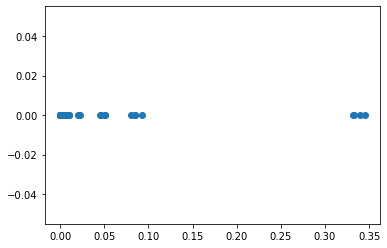

In [141]:
plt.scatter(pp[0,:,0], pc.observed_data.choice.values[:,0])